In [1]:
import threading
import multiprocessing
import logging
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras.layers as kl
import tensorflow.keras.losses as kls
import tensorflow.keras.optimizers as ko
from tqdm.notebook import tqdm
%matplotlib inline

print("TensorFlow Ver: ", tf.__version__)

TensorFlow Ver:  2.1.0


In [2]:
seed = 1234
tf.random.set_seed(seed)
np.random.seed(seed)

In [3]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="2"

In [4]:
# Eager by default!
print("Eager Execution:", tf.executing_eagerly())
print("1 + 2 + 3 + 4 + 5 =", tf.reduce_sum([1, 2, 3, 4, 5]))

Eager Execution: True
1 + 2 + 3 + 4 + 5 = tf.Tensor(15, shape=(), dtype=int32)


In [5]:
class dependent_bandit():
    def __init__(self, difficulty):
        self.num_actions = 2
        self.n_timesteps = 100
        self.difficulty = difficulty
        self.reset()
        
    def set_restless_prob(self):
        self.bandit = np.array([self.restless_list[self.timestep],1 - self.restless_list[self.timestep]])
        
    def reset(self):
        self.timestep = 0
        if self.difficulty == 'restless': 
            variance = np.random.uniform(0,.5)
            self.restless_list = np.cumsum(np.random.uniform(-variance,variance,(150,1)))
            self.restless_list = (self.restless_list - np.min(self.restless_list)) / (np.max(self.restless_list - np.min(self.restless_list))) 
            self.set_restless_prob()
        if self.difficulty == 'easy': 
            bandit_prob = np.random.choice([0.9,0.1])
        if self.difficulty == 'trivial': 
            bandit_prob = np.random.choice([1.0,0.0])
        if self.difficulty == 'medium': 
            bandit_prob = np.random.choice([0.75,0.25])
        if self.difficulty == 'hard': 
            bandit_prob = np.random.choice([0.6,0.4])
        if self.difficulty == 'uniform': 
            bandit_prob = np.random.uniform()
        if self.difficulty != 'independent' and self.difficulty != 'restless':
            self.bandit = np.array([bandit_prob,1 - bandit_prob])
        else:
            self.bandit = np.random.uniform(size=2)
        
    def step(self,action):
        #Get a random number.
        if self.difficulty == 'restless': 
            self.set_restless_prob()
        self.timestep += 1
        bandit = self.bandit[int(action)]
        result = np.random.uniform()
        if result < bandit:
            #return a positive reward.
            reward = 1
        else:
            #return a negative reward.
            reward = 0
        if self.timestep > self.n_timesteps - 1: 
            done = True
        else: 
            done = False
        return reward, done, self.timestep

In [6]:
bandit = dependent_bandit('uniform')

In [7]:
bandit.reset()

In [8]:
bandit.step(0)

(1, False, 1)

In [9]:
class Model:
    def __init__(self, num_actions, batch_size=1, n_features=4, name='meta_policy'):
        '''A3C Model
        Having a stateful LSTM means that you will need to reset the hidden state 
        in between batches yourself if you do want independent batches. 
        The default initial hidden state in Tensorflow is all zeros.
        
        Parameters
        ----------
        learning_rate : float
        num_actions : int
        value_coefficient : float
        entropy_coefficitent : float
        input_shape : n_timesteps, batch_size, n_features
        name : str
        '''
        self.num_actions = num_actions
        self.batch_size = batch_size
        self.n_features = n_features
        self.model = self.create_model()
    
    def create_model(self):
        inputs = kl.Input((self.batch_size, self.n_features))
        self.lstm = kl.LSTM(
            48, name='hidden', 
            stateful=True, 
            time_major=True, # ['time', 'batch', 'features']
            return_sequences=True, 
            recurrent_initializer='zeros'
        )
        self.policy = kl.Dense(
            self.num_actions, name='policy'
        )
        self.value = kl.Dense(
            1, name='value'
        )
        output = self.lstm(inputs)
        value = self.value(output)
        policy = self.policy(output)
        return tf.keras.Model(inputs, [policy, value])
        
    def _compile(self, learning_rate, value_coefficient, entropy_coefficient):
        self.optimizer = ko.Adam(lr=learning_rate)
        self.value_coefficient = value_coefficient
        self.entropy_coefficient = entropy_coefficient

    def predict_action_value(self, obs):
        # Executes `call()` under the hood.
        policy, value = self.model.predict_on_batch(obs)
        policy, value = tf.squeeze(policy, 1), tf.squeeze(value, (1, 2))
        actions = tf.squeeze(tf.random.categorical(policy, 1), 1)
        return actions, value

    def compute_loss(self, actions, advantages, policy_logits, returns, values):
        assert hasattr(self, 'value_coefficient'), "Use _compile"
        # Value loss is typically MSE between value estimates and returns.
        value_loss = kls.mean_squared_error(returns, values)
        # Sparse categorical CE loss obj that supports sample_weight arg on `call()`.
        # `from_logits` argument ensures transformation into normalized probabilities.
        weighted_sparse_ce = kls.SparseCategoricalCrossentropy(from_logits=True)
        # Policy loss is defined by policy gradients, weighted by advantages.
        # Note: we only calculate the loss on the actions we've actually taken.
        actions = tf.cast(actions, tf.int32)
        policy_loss = weighted_sparse_ce(actions, policy_logits, sample_weight=advantages)
        # Entropy loss can be calculated as cross-entropy over itself.
        probs = tf.nn.softmax(policy_logits)
        entropy_loss = tf.reduce_sum(kls.categorical_crossentropy(probs, probs))
        # We want to minimize policy and maximize entropy losses.
        # Here signs are flipped because the optimizer minimizes.
        return policy_loss - self.entropy_coefficient * entropy_loss + self.value_coefficient * value_loss
    
    def train(self, observations, actions, advantages, returns):
        assert hasattr(self, 'optimizer'), 'use _compile'
        with tf.GradientTape() as tape:
            policy_logits, values = self.model(observations, training=True)
            loss = self.compute_loss(actions, advantages, policy_logits, returns, values)
        grads = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))
        return loss

In [10]:
env = dependent_bandit('uniform')
model = Model(env.num_actions)

action = 0
reward, timestep = 0, 0
# reward, done, timestep = env.step(action)
action = tf.one_hot(action, 2)
observation = tf.concat([
        [[reward],[reward]], 
        [action, action],
        [[timestep], [timestep]]], 1)
observation = tf.expand_dims(observation, [1])
# print(observation)
action, value = model.predict_action_value(observation)
print(action, value, observation.shape)

tf.Tensor([0 1], shape=(2,), dtype=int64) tf.Tensor([0.0655949  0.11440822], shape=(2,), dtype=float32) (2, 1, 4)


In [11]:
class Master:
    def __init__(
        self, model, env_name, n_agents=None, n_episodes=250, learning_rate=7e-4, 
        gamma=0.8, value_coefficient=0.05, entropy_coefficient=0.05, name=None):
        # `gamma` is the discount factor; coefficients are used for the loss terms.
        n_agents = n_agents or multiprocessing.cpu_count()
        self.env = dependent_bandit(env_name)
        self.name = name or 'a3c_agent_env_' + env_name
        self.model = model(
            num_actions=self.env.num_actions,
            name=self.name)
        self.model._compile(learning_rate, value_coefficient, entropy_coefficient)
        
        self.agents = [
            Agent(
                model=model(
                    num_actions=self.env.num_actions, 
                    name=f"agent_{i}"), 
                model_global=self.model, 
                env_name=env_name, 
                gamma=gamma, 
                episodes=n_episodes
            ) 
            for i in range(n_agents)
        ]
        self.parameters = {
            'learning_rate': learning_rate,
            'value_coefficient': value_coefficient,
            'entropy_coefficient': entropy_coefficient,
            'gamma': gamma 
        }
        
    def save(self):
        self.data_path.mkdir(parents=True, exist_ok=True)
        logging.info(f"Saving parameters, training_history and weights to {self.data_path}.")
        with open(str(self.data_path / self.name) + '.yaml', 'w') as f:
            yaml.dump(self.parameters, f)
        np.save(str(self.data_path / self.name) + '.npy', self.training_history)
        self.model.model.save_weights(str(self.data_path / self.name))
        
    def load(self):
        logging.warning("Updating parameters, training_history, weights and recompiling model.")
        with open(str(self.data_path / self.name) + '.yaml', 'r') as f:
            self.parameters = yaml.load(f, Loader=yaml.Loader)
        self.training_history = np.load(str(self.data_path / self.name) + '.npy')
        self.model.model.load_weights(str(self.data_path / self.name))
        self.__dict__.update(self.parameters)
        self.model._compile(lr, value_c, entropy_c)
    
    def train(self):
        for agent in self.agents:
            episode_rewards = agent.start()
            
        for agent in self.agents:
            agent.join()
    
    def _predict(self, action, reward, timestep):
        action = np.squeeze(action)
        action_onehot = tf.one_hot(action, self.env.num_actions)
        observation = tf.concat([
            [[reward]], 
            [action_onehot],
            [[timestep]]], 1)
        observation = tf.expand_dims(observation, [1])
        observation = tf.cast(observation, dtype=tf.float32)
        new_action, value = self.model.predict_action_value(observation)
        return new_action, value, observation
        
    def run_episode(self, env=None):
        env = env or self.env

        env.reset()
        # Storage helpers for a single batch of data.
        actions = np.empty((env.n_timesteps,), dtype=np.int32)
        rewards, values = np.empty((2, env.n_timesteps))
        observations = np.empty((self.env.n_timesteps, 1, 4))
        
        self.model.model.reset_states()
        action, reward, timestep, done, step = 0, 0, 0, 0, 0
        while not done:
            # action and reward at t - 1 and timestep at t
            action, value, observations[step] = self._predict(action, reward, timestep + 1)
            reward, done, timestep = env.step(action)
            # rewards, values and actions at t
            rewards[step] = reward
            actions[step] = action
            values[step] = value
            step += 1
        return actions, rewards, values, observations

In [12]:
class Agent(threading.Thread):
    def __init__(self, model, model_global, env_name, gamma, episodes):
        super(Agent, self).__init__()
        self.episodes = episodes
        self.env = dependent_bandit(env_name)
        self.model = model
        self.model_global = model_global
        self.gamma = gamma
        self.model.model.set_weights(self.model_global.model.get_weights())
        
    def _predict(self, action, reward, timestep):
        action = np.squeeze(action)
        action_onehot = tf.one_hot(action, self.env.num_actions)
        observation = tf.concat([
            [[reward]], 
            [action_onehot],
            [[timestep]]], 1)
        observation = tf.expand_dims(observation, [1])
        observation = tf.cast(observation, dtype=tf.float32)
        new_action, value = self.model.predict_action_value(observation)
        return new_action, value, observation

    def run(self):
        # Training loop: collect samples, send to optimizer, repeat episodes times.
        self.training_history = []
        for episode in tqdm(range(self.episodes)):
            actions, rewards, values, observations = self.run_episode()
            self.training_history.append(np.sum(rewards))

            logging.info("Episode: %03d, Reward: %03d" % (len(self.training_history) - 1, self.training_history[-1]))
            
            # `next_value` is the bootstrap value estimate of the future state (critic).
            _, next_value, _ = self._predict(actions[-1], rewards[-1], observations[-1,0,3] + 1)
            
            returns, advantages = self._returns_advantages(rewards, values, next_value)
            observations = tf.cast(observations, dtype=tf.float32)
            losses = self.model_global.train(observations, actions, advantages, returns)
            self.model.model.set_weights(self.model_global.model.get_weights())
            logging.debug("[%d/%d] Losses: policy loss %s value loss %s" % (episode + 1, self.episodes, losses[1], losses[2]))

    def run_episode(self, env=None):
        env = env or self.env

        env.reset()
        # Storage helpers for a single batch of data.
        actions = np.empty((env.n_timesteps,), dtype=np.int32)
        rewards, values = np.empty((2, env.n_timesteps))
        observations = np.empty((self.env.n_timesteps, 1, 4))
        
        self.model.model.reset_states()
        action, reward, timestep, done, step = 0, 0, 0, 0, 0
        while not done:
            # action and reward at t - 1 and timestep at t
            action, value, observations[step] = self._predict(action, reward, timestep + 1)
            reward, done, timestep = env.step(action)
            # rewards, values and actions at t
            rewards[step] = reward
            actions[step] = action
            values[step] = value
            step += 1
        return actions, rewards, values, observations
    
    def _returns_advantages(self, rewards, values, next_value):
        # `next_value` is the bootstrap value estimate of the future state (critic).
        returns = np.append(np.zeros_like(rewards), next_value, axis=-1)
        # Returns are calculated as discounted sum of future rewards.
        for t in reversed(range(rewards.shape[0])):
            returns[t] = rewards[t] + self.gamma * returns[t + 1]
        returns = returns[:-1]
        # Advantages are equal to returns - baseline (value estimates in our case).
        advantages = returns - values
        return returns, advantages

In [13]:
# logging.getLogger().setLevel(logging.INFO)
# logging.getLogger().setLevel(logging.DEBUG)
logging.getLogger().setLevel(logging.WARNING)

master = Master(Model, 'easy', 20, 1000)

_, rewards, _, _ = master.run_episode()
print(sum(rewards))

44.0


In [14]:
master.train()

Finished training! Testing...
Total Episode Reward: 66 out of 100


Text(0, 0.5, 'Total Reward')

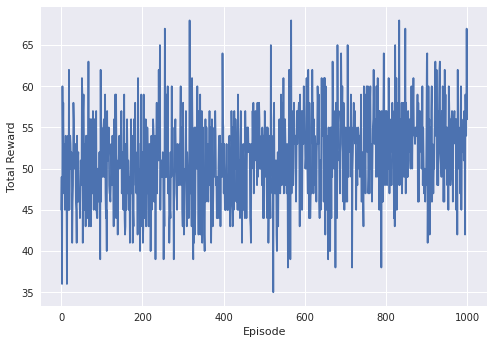

In [16]:
agent_rewards_history = master.agents[0].training_history
print("Finished training! Testing...")
_, rewards, _, _ = master.run_episode()
print("Total Episode Reward: %d out of 100" % sum(rewards))

plt.style.use('seaborn')
plt.plot(np.arange(len(agent_rewards_history)), agent_rewards_history)
plt.xlabel('Episode')
plt.ylabel('Total Reward')

In [21]:
class Benchmark:
    def __init__(self, agent, env_name=None, n_episodes=300):
        self.agent = agent
        self.env_name = env_name or agent.env_name
        self.env = dependent_bandit(self.env_name)
        self.n_episodes = n_episodes
    
    def evaluate(self):
        rewards = np.empty((self.n_episodes, env.n_timesteps))
        actions = np.empty((self.n_episodes, env.n_timesteps))
        values = np.empty((self.n_episodes, env.n_timesteps))
        bandits = np.empty((self.n_episodes, 2))
        for episode in tqdm(range(self.n_episodes)):
            actions[episode], rewards[episode], values[episode], _ = self.agent.run_episode(self.env)
            bandits[episode] = self.env.bandit
        self.episodes = {
            'rewards': rewards,
            'actions': actions,
            'values': values,
            'bandits': bandits
        }
            
    def hist(self):
        if not hasattr(self, 'episodes'):
            self.evaluate()
        plt.hist(self.episodes['rewards'].sum(1) / (self.env.bandit.max() * 100))
        
    def plot_cumulative_regret(self):
        if not hasattr(self, 'episodes'):
            self.evaluate()
        if self.env.difficulty == 'uniform':
            raise NotImplementedError
        regret = self.env.bandit.max() - self.episodes['rewards'].mean(0)
        plt.plot(np.cumsum(regret))
        
    def plot_rewards(self):
        import matplotlib.patches as mpatches
        if not hasattr(self, 'episodes'):
            self.evaluate()

        im = plt.imshow(self.episodes['rewards'], cmap='binary', origin='lower', interpolation='nearest')
        
#         patches = [mpatches.Patch(color=im.cmap(im.norm(0)), label="Sub-optimal choice")]
#         plt.legend(handles=patches, )
        
        plt.gca().set_aspect('auto')
        plt.grid(False)
    
    def plot_actions(self):
        import matplotlib.patches as mpatches
        if not hasattr(self, 'episodes'):
            self.evaluate()
        actions_optimal = np.empty_like(self.episodes['actions'])
        _itr = zip(self.episodes['actions'], np.argmax(self.episodes['bandits'], 1))
        
        for i, (actions_episode, optimal_choice) in enumerate(_itr):
            actions_optimal[i] = actions_episode == optimal_choice

        im = plt.imshow(actions_optimal, cmap='Greens_r', origin='lower', interpolation='nearest')
        
        patches = [mpatches.Patch(color=im.cmap(im.norm(0)), label="Sub-optimal choice")]
        plt.legend(handles=patches, )
        
        plt.gca().set_aspect('auto')
        plt.grid(False)

In [22]:
b = Benchmark(master, 'easy')
b.evaluate()

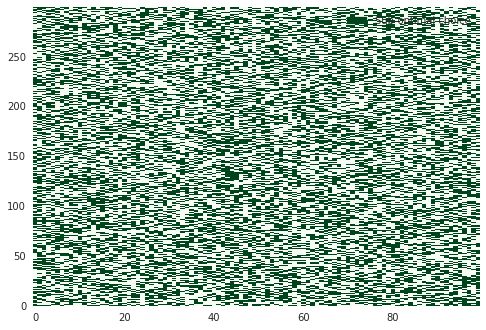

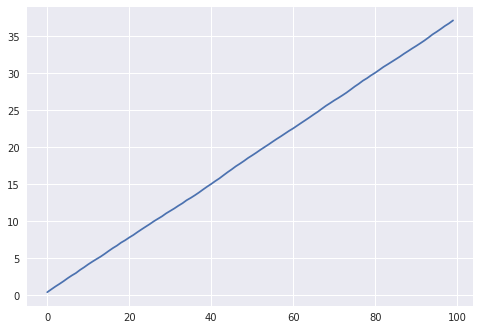

In [24]:
b.plot_actions()
plt.figure()
b.plot_cumulative_regret()